# YellowTaxi Tirp Data Analysis 

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("241210_04_yellowtaxi_trip_count").getOrCreate()
spark

24/12/12 11:21:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/12 11:21:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# 파일 불러오기 

import os

trip_files = '/trips/*'
zone_file = 'taxi+_zone_lookup.csv'
directory = os.path.join(os.getcwd(), 'data')

In [3]:
trips_df = spark.read.csv(f'file:///{directory}/{trip_files}', inferSchema=True, header=True)

In [4]:
zone_df = spark.read.csv(f'file:///{directory}/{zone_file}', inferSchema=True, header=True)

## 데이터 자료 조사

In [5]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [6]:
trips_df.show(5)
zone_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       2| 2021-03-01 00:22:02|  2021-03-01 00:23:22|              1|          0.0|         1|                 N|         264|         264|           2|        3.0|  0.5|    0.5|       0.0|         0.0|                  0.3

In [7]:
# 뷰 만들기

trips_df.createOrReplaceTempView('trips')
zone_df.createOrReplaceTempView('zone')

In [8]:
# 쿼리 생성

query = '''
SELECT
t.VendorID,
To_DATE(t.tpep_pickup_datetime) as pickup_date,
To_DATE(t.tpep_dropoff_datetime) as dropoff_date,
HOUR(t.tpep_pickup_datetime) as pickup_time,
HOUR(t.tpep_dropoff_datetime) as dropoff_time,
t.passenger_count,
t.trip_distance,
t.tip_amount,
t.total_amount,
t.payment_type,
pz.Zone as pickup_zone,
dz.Zone as dropoff_zone,
T.congestion_surcharge  

FROM trips t

LEFT JOIN zone pz ON t.PULocationID = pz.LocationID
LEFT JOIN zone dz ON t.DOLocationID = dz.LocationID
'''
comb_df = spark.sql(query)
comb_df.show()

+--------+-----------+------------+-----------+------------+---------------+-------------+----------+------------+------------+--------------------+--------------------+--------------------+
|VendorID|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|tip_amount|total_amount|payment_type|         pickup_zone|        dropoff_zone|congestion_surcharge|
+--------+-----------+------------+-----------+------------+---------------+-------------+----------+------------+------------+--------------------+--------------------+--------------------+
|       2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|       0.0|         4.3|           2|                  NV|                  NV|                 0.0|
|       2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|       0.0|         3.8|           2|      Manhattanville|      Manhattanville|                 0.0|
|       2| 2021-03-01|  2021-03-01|          

In [9]:
# comb_df를 view 생성

comb_df.createOrReplaceTempView("comb")

In [10]:
comb_df.describe()

DataFrame[summary: string, VendorID: string, pickup_time: string, dropoff_time: string, passenger_count: string, trip_distance: string, tip_amount: string, total_amount: string, payment_type: string, pickup_zone: string, dropoff_zone: string, congestion_surcharge: string]

In [11]:
spark.sql(query).explain()

== Physical Plan ==
*(3) Project [VendorID#16, cast(tpep_pickup_datetime#17 as date) AS pickup_date#877, cast(tpep_dropoff_datetime#18 as date) AS dropoff_date#878, hour(cast(tpep_pickup_datetime#17 as timestamp), Some(Asia/Seoul)) AS pickup_time#879, hour(cast(tpep_dropoff_datetime#18 as timestamp), Some(Asia/Seoul)) AS dropoff_time#880, passenger_count#19, trip_distance#20, tip_amount#29, total_amount#32, payment_type#25, Zone#70 AS pickup_zone#881, Zone#885 AS dropoff_zone#882, congestion_surcharge#33]
+- *(3) BroadcastHashJoin [DOLocationID#24], [LocationID#883], LeftOuter, BuildRight, false
   :- *(3) Project [VendorID#16, tpep_pickup_datetime#17, tpep_dropoff_datetime#18, passenger_count#19, trip_distance#20, DOLocationID#24, payment_type#25, tip_amount#29, total_amount#32, congestion_surcharge#33, Zone#70]
   :  +- *(3) BroadcastHashJoin [PULocationID#23], [LocationID#68], LeftOuter, BuildRight, false
   :     :- FileScan csv [VendorID#16,tpep_pickup_datetime#17,tpep_dropoff_dat

In [12]:
# 테스트 - 픽업타임이 0 이상인 픽업날짜와 픽업타입 추출

query = '''
SELECT pickup_date, pickup_time
FROM comb
WHERE pickup_time > 0 
'''

spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-03-01|         22|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
+-----------+-----------+
only showing top 20 rows



In [13]:
# 테스트2 - 픽업 날짜가 2020년 12월 31일 이전 픽업날짜와 픽업타입 추출

query = '''
SELECT pickup_date, pickup_time
FROM comb
WHERE pickup_date < '2020-12-31' 
'''

spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|         16|
| 2009-01-01|         16|
| 2009-01-01|          0|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



In [15]:
#실행 계획, 실행 결과 (4040)
query2 = '''
SELECT pickup_date, pickup_time
FROM comb
WHERE pickup_time > 0 and pickup_time <= 12
'''
spark.sql(query2).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
+-----------+-----------+
only showing top 20 rows



In [16]:
#실행 계획, 실행 결과 (4040)
query3 = '''
select pickup_date , count(*) as trip_count
from comb 
where pickup_time > 0
group by pickup_date
order by pickup_date
'''
spark.sql(query3).show()

+-----------+----------+
|pickup_date|trip_count|
+-----------+----------+
| 2002-12-31|         1|
| 2003-01-05|         1|
| 2004-04-04|         1|
| 2008-12-31|        26|
| 2009-01-01|        46|
| 2020-12-31|        16|
| 2021-01-01|     23649|
| 2021-01-02|     34045|
| 2021-01-03|     25881|
| 2021-01-04|     44210|
| 2021-01-05|     46539|
| 2021-01-06|     49210|
| 2021-01-07|     50013|
| 2021-01-08|     50122|
| 2021-01-09|     39407|
| 2021-01-10|     29275|
| 2021-01-11|     46568|
| 2021-01-12|     49878|
| 2021-01-13|     51045|
| 2021-01-14|     52763|
+-----------+----------+
only showing top 20 rows



### 1. 운행 거리와 요금의 상관 관계 분석

In [34]:
query_1 = '''
SELECT trip_distance, ROUND(AVG(total_amount),2) as avg_total_amount
FROM comb
GROUP BY trip_distance
ORDER BY avg_total_amount DESC
'''
data = spark.sql(query_1) 
data.show()

+-------------+----------------+
|trip_distance|avg_total_amount|
+-------------+----------------+
|       964.27|          2413.8|
|        427.7|          2292.4|
|       821.54|          2059.3|
|        267.7|          1108.2|
|        260.5|           894.2|
|        271.4|          872.54|
|       344.88|           865.3|
|        323.0|          838.05|
|       215.95|          832.54|
|        282.1|          736.85|
|        270.2|           715.3|
|       161.38|          682.48|
|       258.98|           654.8|
|       170.26|           653.1|
|        99.48|          645.21|
|        220.4|          631.42|
|       247.37|           621.3|
|       224.16|           602.3|
|       103.98|           601.8|
|       277.74|           600.3|
+-------------+----------------+
only showing top 20 rows



In [35]:
data.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- avg_total_amount: double (nullable = true)



In [36]:
# 상관관계?

#from pyspark.ml.feature import *
#from pyspark.ml.stat import *
# assembler = VectorAssembler(inputCols=["trip_distance", "avg_total_amount"], outputCol="features", handleInvalid="skip")
# df_assembled = assembler.transform(data)

# # Corr()
# corr = Correlation.corr(df_assembled, "features", method="pearson").head()[0]
# print(corr)
# corr_array = corr.toArray()
# result = corr_array[0,1]
# print(result)

import pandas as pd

data = data.toPandas()

corr = data['trip_distance'].corr(data['avg_total_amount'])
print(corr)

-0.15085739557073535


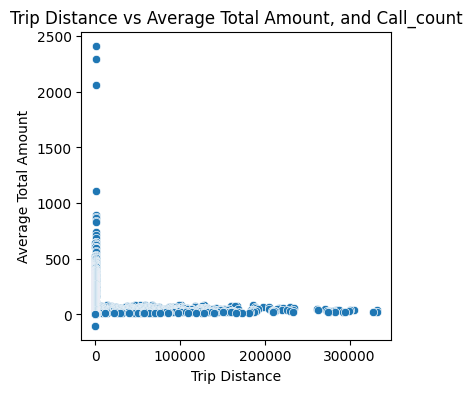

In [40]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.scatterplot(x='trip_distance', y='avg_total_amount', data=data)
plt.title("Trip Distance vs Average Total Amount, and Call_count")
plt.xlabel('Trip Distance')
plt.ylabel('Average Total Amount')
plt.show()

### 2. 피크 시간대 요금 분석 - 가장 운행 기록이 많은 시간 대

In [41]:
query_2 = '''
SELECT pickup_time, count(*) as trip_count, Round(SUM(total_amount),2) as Total_amount
FROM comb
GROUP BY pickup_time
ORDER BY trip_count DESC
'''
spark.sql(query_2).show(5) 

+-----------+----------+-------------+
|pickup_time|trip_count| Total_amount|
+-----------+----------+-------------+
|         15|   1091871|2.034362246E7|
|         18|   1087217|2.020262881E7|
|         17|   1085226|2.093609435E7|
|         14|   1084111|1.970667334E7|
|         16|   1043498|2.056582042E7|
+-----------+----------+-------------+
only showing top 5 rows



### 3. 지불 유형별 요금, 팁 분석

In [ ]:
query_3 = '''
SELECT payment_type, count(*) AS payment_count,SUM(tip_amount) as total_tips, SUM(total_amount) AS total_amount
FROM comb
GROUP BY payment_type
ORDER BY payment_type
'''
spark.sql(query_3).show()

### 4. 승차지역/하차지역별 평균 거리, 요금

In [ ]:
query_4 = '''
SELECT pickup_zone, dropoff_zone, avg(trip_distance) as avg_trip_distance, sum(total_amount) as total_amount
FROM comb
GROUP BY pickup_zone,dropoff_zone
ORDER BY avg_trip_distance DESC
'''
spark.sql(query_4).show()

### 5. 팁의 비율에 따른 거리

In [ ]:
query_5 = '''
SELECT 
    (tip_amount/total_amount)*100 as tips_percentage,
    AVG(trip_distance) AS avg_trip_distance
FROM comb
GROUP BY tips_percentage
ORDER BY avg_trip_distance DESC
'''
spark.sql(query_5).show()

In [ ]:
# 팁 카테고리 지정 

query_5 = '''
SELECT 
    CASE 
        WHEN tips_percentage < 20 THEN "0~20%"
        WHEN tips_percentage < 40 THEN "20~40%"
        WHEN tips_percentage < 60 THEN "40~60%"
        WHEN tips_percentage < 80 THEN "60~80%"
        ELSE "80% 이상"
    END as tip_category,
    AVG(trip_distance) AS avg_trip_distance
FROM (
    SELECT 
        (tip_amount / total_amount) * 100 as tips_percentage,
        trip_distance
    FROM comb
) AS subquery
GROUP BY tip_category
ORDER BY tip_category
'''

spark.sql(query_5).show()


### 6. 지역별 혼잡도 추가 요금 확인

In [ ]:
query_6 = '''
SELECT pickup_zone, dropoff_zone, avg(congestion_surcharge) as avg_congestion_surcharge
FROM comb
GROUP BY pickup_zone, dropoff_zone
ORDER BY avg_congestion_surcharge DESC
'''
spark.sql(query_6).show()

In [ ]:
#spark.stop()